In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
import numpy as np
# from custom_dataset import CustomDataset, ResidualBlock, ResNet,CustomResNet50, GCN
from torch_geometric.data import Data
import plotly.graph_objects as go
from torch_geometric.nn import MLP
from pytorch_metric_learning.losses import NTXentLoss
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch_geometric.transforms as T


In [16]:
class Net(torch.nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        x = x.to(device)
        edge_index = edge_index.to(device)
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        z = z.to(device)
        edge_label_index = edge_label_index.to(device)
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


def to_device(data, device):
    if isinstance(data, (tuple, list)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, device='cpu',num_epochs=100):

    for epoch in range(num_epochs):

        model.train()
        optimizer.zero_grad()
        x, edge_index = to_device((train_data.x, train_data.edge_index), device)
        z = model.encode(x ,edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [17]:
feature_vectors_np = np.load("outputs_cnn.npy")
feature_vectors_np = np.squeeze(feature_vectors_np)

In [18]:
filenames_df = pd.read_csv('filenames.csv', header=None)  # Assuming there's no header
filenames_df.columns = ['song']  # Name the column for easier reference
filename_set = set(filenames_df['song'])

In [19]:
user_liked_songs_df = pd.read_csv("processed_user_spotify_dataset.csv")
user_liked_songs_df = user_liked_songs_df[user_liked_songs_df['liked_songs'].isin(filename_set)]
len(user_liked_songs_df)

488489

In [20]:
song_to_index = {song: i for i, song in enumerate(filenames_df['song'])}
user_to_index = {user: i + len(song_to_index) for i, user in enumerate(user_liked_songs_df['user_id'].unique())}

# Total number of nodes is the sum of unique songs and users
num_nodes = len(song_to_index) + len(user_to_index)

In [ ]:
edges = []
for _, row in user_liked_songs_df.iterrows():
    user_idx = user_to_index[row['user_id']]
    song_idx = song_to_index[row['liked_songs']]
    edges.append([user_idx, song_idx])  # User -> Song edge

edge_index_np = np.array(edges).T  # Transpose to get 2 x num_edges shape
np.save("graph_edges",edge_index_np)

In [ ]:
features = np.zeros((num_nodes, feature_vectors_np.shape[1]))
features[:len(filenames_df['song'])] = feature_vectors_np

In [ ]:
for user, idx in user_to_index.items():
    liked_songs = user_liked_songs_df[user_liked_songs_df['user_id'] == user]['liked_songs']
    liked_song_indices = [song_to_index[song] for song in liked_songs]
    user_features = np.mean(feature_vectors_np[liked_song_indices], axis=0)
    features[idx] = user_features
np.save("graph_features",features)

In [22]:
edge_index_np= np.load("graph_edges.npy")
features=np.load("graph_features.npy")

In [23]:
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

x = torch.tensor(features, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [24]:
split = T.RandomLinkSplit(
    num_val=0.3,
    num_test=0.05,
    is_undirected=False,
    add_negative_train_samples=False,
)

In [25]:
train_data, val_data, test_data = split(data)

In [24]:
model = Net(data.num_features, 128, 64)
if torch.cuda.is_available():
    model.cuda()  # Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = train_data.to(device)
val_data = val_data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion, device=device,num_epochs=3001)

In [18]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [26]:
model = Net(512, 128, 64)
checkpoint=torch.load("model_state_dict.pth")
model.load_state_dict(checkpoint)
model.eval()


Net(
  (conv1): GCNConv(512, 128)
  (conv2): GCNConv(128, 64)
)

# Results

In [27]:
index_to_song = {i: song for i, song in enumerate(filenames_df['song'])}
index_to_user = {i + len(song_to_index):user for i, user in enumerate(user_liked_songs_df['user_id'].unique())}
index_to_label = {**index_to_song, **index_to_user}

In [28]:
nodes= list(range(data.num_nodes))
song_nodes = [node for node in nodes if node < 5730]  # Song nodes have indices < 1718
user_nodes = [node for node in nodes if node >= 5730]  # User nodes have indices >= 1718


In [29]:
# You want only (user, song) pairs
possible_edges = {(user, song) for user in user_nodes for song in song_nodes}

In [30]:
existing_edges_set = set(tuple(x) for x in data.edge_index.t().tolist())

In [31]:
new_edges = [edge for edge in possible_edges if edge not in existing_edges_set]

# new_edges now contains the non-existing edges as a list of tuples
print("Number of possible new edges:", len(new_edges))

Number of possible new edges: 75106700


In [32]:
import random
new_sampled_edges = random.sample(new_edges, len(existing_edges_set))
existing_edges_list= list(existing_edges_set)

edges_to_predict = new_sampled_edges+existing_edges_list

In [33]:

predict_edges_tensor = torch.tensor(edges_to_predict, dtype=torch.long)
predict_edges_tensor = predict_edges_tensor.t()

In [34]:
predict_edges_tensor.shape

torch.Size([2, 817940])

In [35]:
def decode_in_batches(model, z, edge_label_index, batch_size=10):
    num_edges = edge_label_index.size(1)
    results = torch.empty(num_edges, dtype=torch.float, device=z.device)

    for start in (range(0, num_edges, batch_size)):
        end = min(start + batch_size, num_edges)
        batch_edges = edge_label_index[:, start:end]
        batch_results = model.decode(z, batch_edges)
        results[start:end] = batch_results

    return results

def apply_sigmoid_in_batches(z, batch_size=30):
    sigmoid_z = torch.empty_like(z)
    for start in range(0, z.size(0), batch_size):
        end = start + batch_size
        sigmoid_z[start:end] = torch.sigmoid(z[start:end])
    return sigmoid_z

In [36]:
model.eval()

Net(
  (conv1): GCNConv(512, 128)
  (conv2): GCNConv(128, 64)
)

In [37]:
if torch.cuda.is_available():
    model.cuda()  # Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [38]:
z = model.encode(data.x, data.edge_index)

In [39]:
edge_prob = decode_in_batches(model, z, predict_edges_tensor, batch_size=10)

In [40]:
sigmoid_z = apply_sigmoid_in_batches(edge_prob)

In [41]:
sigmoid_z=sigmoid_z.detach().cpu()
predict_edges_tensor=predict_edges_tensor.detach().cpu()

In [42]:
predict_edges_tensor

tensor([[14132,  8762, 10111,  ..., 18581,  8064,  8377],
        [  798,     6,  1567,  ...,  1539,  3484,  1729]])

In [32]:
sigmoid_z.shape

torch.Size([817940])

In [43]:
threshold = 0.8
predicted_edges = predict_edges_tensor[:, sigmoid_z > threshold]
predicted_edges.shape

torch.Size([2, 506550])

In [88]:
predicted_edges_transposed = predicted_edges.t()

# Convert each pair to a tuple and add to a set
predicted_edges_set = {tuple(edge.numpy()) for edge in predicted_edges_transposed}

In [101]:
true_positives = sum(1 for edge in predicted_edges_set if tuple(edge) in existing_edges_set)
true_positives

364298

In [100]:
false_positives = sum(1 for edge in predicted_edges_set if tuple(edge) not in existing_edges_set)
false_positives

141087

In [103]:
true_positives/(true_positives+false_positives)

0.7208326325474638

In [ ]:
true_positives/len(existing_edges_set)

In [96]:
(data.edge_index.shape)

torch.Size([2, 488489])

In [84]:
predicted_edges.numpy()

array([[14543, 15154,  8852, ..., 18581,  8064,  8377],
       [ 4396,  1744,  4797, ...,  1539,  3484,  1729]])

In [85]:
existing_edges_set

{(11450, 1792),
 (17305, 214),
 (17874, 2586),
 (6102, 2612),
 (14787, 4345),
 (10520, 1858),
 (6998, 3689),
 (15998, 3740),
 (7686, 1057),
 (16239, 419),
 (6225, 733),
 (8768, 4768),
 (8804, 4425),
 (10855, 1582),
 (7959, 2155),
 (11763, 3420),
 (11138, 3368),
 (17898, 4865),
 (8803, 790),
 (9799, 2475),
 (11819, 4483),
 (12603, 4565),
 (15650, 3407),
 (7250, 877),
 (14019, 982),
 (8384, 4778),
 (16859, 2729),
 (18817, 3859),
 (15957, 4089),
 (16506, 5085),
 (16635, 769),
 (5771, 4885),
 (15081, 4418),
 (13338, 998),
 (6242, 4470),
 (7140, 5620),
 (18064, 2309),
 (9261, 2018),
 (14108, 650),
 (12554, 4299),
 (8574, 1088),
 (17461, 3736),
 (6602, 1780),
 (7846, 4321),
 (15912, 1313),
 (16070, 4905),
 (6135, 3068),
 (11548, 5309),
 (10180, 1012),
 (13201, 885),
 (14297, 522),
 (11637, 3846),
 (14665, 5644),
 (15119, 2616),
 (5915, 1981),
 (17486, 2453),
 (10118, 3517),
 (10822, 1418),
 (15911, 1061),
 (9930, 3466),
 (12640, 259),
 (6196, 1442),
 (11576, 2789),
 (17822, 867),
 (14551, 65

In [44]:
# Convert sub_nodes to a set for faster look-up
sub_nodes_set = set(nodes)

# Function to check if an edge is within sub_nodes
def edge_in_sub_nodes(edge, sub_nodes_set):
    # Check if both nodes of the edge are in sub_nodes
    return edge[0] in sub_nodes_set and edge[1] in sub_nodes_set

# Filter edges
sub_edge_indices = [i for i, edge in enumerate(data.edge_index.t().tolist()) if edge_in_sub_nodes(edge, sub_nodes_set)]

# Extracting the subgraph edges based on filtered indices
sub_edges = data.edge_index[:, sub_edge_indices]

# sub_edges now contains only the edges that connect nodes within sub_nodes


In [45]:
sub_edges = [(int(source), int(target)) for source, target in sub_edges.t().tolist()]
predicted_edges = [(int(source), int(target)) for source, target in predicted_edges.t().tolist()]

In [46]:
# Initialize an empty dictionary to hold user to predicted songs mapping
user_to_predicted_songs = {}

# Iterate over predicted edges
for edge in predicted_edges:
    if edge[0] >5730:
        user_node, song_node = edge

    else:
        song_node,user_node = edge


    
#     # Check if this edge is a user to song edge based on your node ID conventions
    if user_node in index_to_user and song_node in index_to_song:
        # Map back to user ID and song name
        user_id = index_to_user[user_node]
        song_name = index_to_song[song_node]
        
        # Initialize the list for this user if it doesn't exist
        if user_id not in user_to_predicted_songs:
            user_to_predicted_songs[user_id] = []
        
        # Append the song name to the user's list
        user_to_predicted_songs[user_id].append(song_name)


# Create a list of tuples (user, song) for DataFrame construction
user_song_pairs = [(user, song) for user, songs in user_to_predicted_songs.items() for song in songs]
predicted_df = pd.DataFrame(user_song_pairs, columns=['User', 'Predicted Song'])


In [50]:
import csv

# Initialize an empty dictionary to hold user to liked songs mapping based on subgraph
user_to_liked_songs = {}

# Iterate over sub_edges to populate user_to_liked_songs
for edge in sub_edges:
    # Split edge into user and song nodes based on your node ID conventions
    if edge[0] > 5730:
        user_node, song_node = edge
    else:
        song_node, user_node = edge

    # Ensure both nodes are in the subgraph and map back to user ID and song name
    if user_node in index_to_user and song_node in index_to_song:
        user_id = index_to_user[user_node]
        song_name = index_to_song[song_node]

        # Initialize the list for this user if it doesn't exist
        if user_id not in user_to_liked_songs:
            user_to_liked_songs[user_id] = []

        # Append the song name to the user's liked list
        user_to_liked_songs[user_id].append(song_name)

# Open a CSV file to write the output
with open('user_likes_and_predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['User ID', 'Liked Songs', 'Predicted Songs'])

    # Write the liked songs and predicted songs for each user to the CSV file
    for user in user_to_liked_songs.keys():
        liked_songs = '; '.join(user_to_liked_songs[user])  # Combine all liked songs into a single string separated by semicolons
        predicted_songs = '; '.join(user_to_predicted_songs[user]) if user in user_to_predicted_songs else 'None'
        
        # Write to the CSV file
        writer.writerow([user, liked_songs, predicted_songs])


In [51]:
import csv

# Load the song cluster data from 'song cluster.csv'
song_to_cluster = {}
with open('song_clusters_sorted.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')  # Assuming the data is tab-delimited
    next(reader)  # Skip header row
    for row in reader:
        song_name, cluster_label = row
        song_to_cluster[song_name] = cluster_label

with open('user_likes_and_predictions_with_clusters.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['User ID', 'Liked Songs with Clusters', 'Predicted Songs with Clusters'])

    # Write the liked songs and predicted songs for each user to the CSV file
    for user in user_to_liked_songs.keys():
        # Format liked songs with cluster labels
        liked_songs_with_clusters = [
            f'{song} (Cluster {song_to_cluster.get(song, "N/A")})' for song in user_to_liked_songs[user]
        ]
        liked_songs_str = '; '.join(liked_songs_with_clusters)

        # Format predicted songs with cluster labels
        if user in user_to_predicted_songs:
            predicted_songs_with_clusters = [
                f'{song} (Cluster {song_to_cluster.get(song, "N/A")})' for song in user_to_predicted_songs[user]
            ]
            predicted_songs_str = '; '.join(predicted_songs_with_clusters)
        else:
            predicted_songs_str = 'None'

        # Write to the CSV file
        writer.writerow([user, liked_songs_str, predicted_songs_str])


In [49]:
user_to_liked_songs

{}

In [58]:
import csv


# Open the CSV file
with open('user_likes_and_predictions_with_clusters.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user_id = row["User ID"]
        liked_songs = row["Liked Songs with Clusters"].split('; ')
        predicted_songs = row['Predicted Songs with Clusters'].split('; ')
        
        # Create a text file for each user
        with open(f'{user_id}_songs.txt', 'w') as file:
            file.write(f'{user_id}\n')
            file.write('Liked songs:\n')
            file.write('----\n')
            for song in liked_songs:
                file.write(f'- {song}\n')
            file.write('\nPredicted songs:\n')
            file.write('----\n')
            for song in predicted_songs:
                file.write(f'- {song}\n')



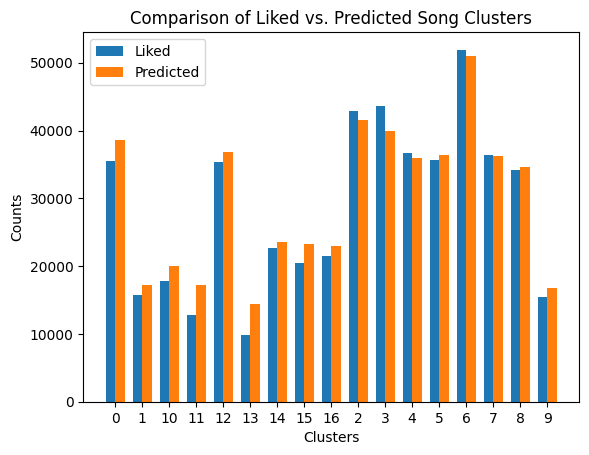

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('user_likes_and_predictions_with_clusters.csv')

data['Liked Clusters'] = data['Liked Songs with Clusters'].apply(lambda x: [s.split(' (Cluster ')[1][:-1] for s in x.split('; ')])
data['Predicted Clusters'] = data['Predicted Songs with Clusters'].apply(lambda x: [s.split(' (Cluster ')[1][:-1] for s in x.split('; ')])


liked_clusters = data['Liked Clusters'].explode().value_counts().sort_index()
predicted_clusters = data['Predicted Clusters'].explode().value_counts().sort_index()

# Creating the grouped bar chart
fig, ax = plt.subplots()
index = range(len(liked_clusters))
bar_width = 0.35

rects1 = ax.bar(index, liked_clusters, bar_width, label='Liked')
rects2 = ax.bar([p + bar_width for p in index], predicted_clusters, bar_width, label='Predicted')

ax.set_xlabel('Clusters')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Liked vs. Predicted Song Clusters')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(liked_clusters.index)
ax.legend()

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load  CSV data
data = pd.read_csv('user_likes_and_predictions_with_clusters.csv')

# Function to extract clusters from the song-cluster strings
def extract_clusters(songs_with_clusters):
    clusters = [s.split(' (Cluster ')[1][:-1] for s in songs_with_clusters.split('; ')]
    return pd.Series(clusters).value_counts()

# Apply the function to both Liked and Predicted songs columns
data['Liked Clusters'] = data['Liked Songs with Clusters'].apply(extract_clusters)
data['Predicted Clusters'] = data['Predicted Songs with Clusters'].apply(extract_clusters)

# Concatenate all user data for liked and predicted songs into two series
all_liked_clusters = pd.concat(list(data['Liked Clusters']), axis=1, sort=False).fillna(0).sum(axis=1)
all_predicted_clusters = pd.concat(list(data['Predicted Clusters']), axis=1, sort=False).fillna(0).sum(axis=1)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Liked': all_liked_clusters,
    'Predicted': all_predicted_clusters
}).fillna(0)

# Plotting
plot_data.plot(kind='bar', stacked=True, color=['#4CAF50', '#FFC107'])
plt.title('Distribution of Liked vs. Predicted Song Clusters')
plt.xlabel('Cluster')
plt.ylabel('Total Count of Songs')
plt.xticks(rotation=0)
plt.legend(title='Song Type')
plt.show()


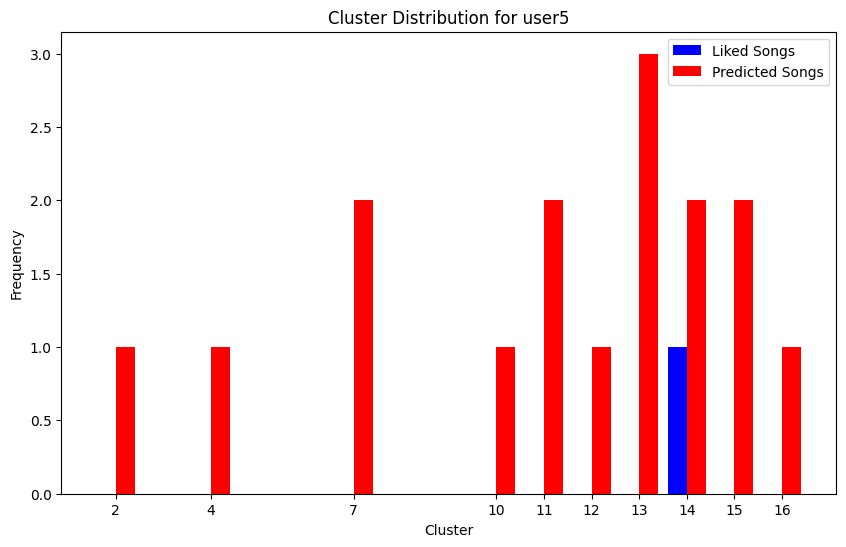

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from io import StringIO

df = pd.read_csv('user_likes_and_predictions_with_clusters.csv')

# Function to extract clusters
def extract_clusters(song_data):
    clusters = [int(part.split("Cluster ")[1].strip(")")) for part in song_data.split("; ")]
    return Counter(clusters)

# Select data for a specific user
user_id = 'user6'
liked_songs = df[df['User ID'] == user_id]['Liked Songs with Clusters'].values[0]
predicted_songs = df[df['User ID'] == user_id]['Predicted Songs with Clusters'].values[0]

# Count clusters for liked and predicted songs
liked_clusters = extract_clusters(liked_songs)
predicted_clusters = extract_clusters(predicted_songs)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
clusters = list(set(liked_clusters.keys()).union(set(predicted_clusters.keys())))
liked_counts = [liked_clusters.get(cluster, 0) for cluster in clusters]
predicted_counts = [predicted_clusters.get(cluster, 0) for cluster in clusters]

ax.bar([x - 0.2 for x in clusters], liked_counts, width=0.4, color='b', label='Liked Songs')
ax.bar([x + 0.2 for x in clusters], predicted_counts, width=0.4, color='r', label='Predicted Songs')
ax.set_title(f'Cluster Distribution for {user_id}')
ax.set_xlabel('Cluster')
ax.set_ylabel('Frequency')
ax.set_xticks(clusters)
ax.set_xticklabels(clusters)
plt.legend()
plt.show()
